<a href="https://colab.research.google.com/github/sametony/lifelines/blob/master/07-Advanced-Regression/02_Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survival Analysis

In [3]:
# !pip install lifelines
import lifelines
import numpy as np
import matplotlib.pyplot as plt # version > 3.0
import pandas as pd

# plt.style.use('seaborn')

**Contents**
* [Overview](#Overview)
    * Censorship in Data
    * Hazard Function - the dangerous bathtub
    * Survival Function (aka reliability function)
    * Ways to estimate/model survival analysis - terms to be aware of
    * `lifelines` package
* [Example 1: Leukemia](#Example-1:-Leukemia)
    * Kaplan-Meier survival estimate
    * Cox Proportional Hazards Model -- Survival Regression
* [Example 2: Recidivism](#Example-2:-Recidivism)
* [Example 3: Heart Attack Survival](#Example-3:-Heart-Attack-Survival])
* [Example 4: Customer Churn](#Example-4:-Customer-Churn)

**Resources**
- [Wikipedia on Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis)
- [Wikipedia on Survival functions](https://en.wikipedia.org/wiki/Survival_function)
- [Summary of survival analysis by a biostatistician](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Survival/BS704_Survival_print.html)
- [Another medical statistics article on survival analysis](https://www.sciencedirect.com/science/article/pii/S1756231716300639)
- [Survival analysis using R lecture slides](http://www.stat.columbia.edu/~madigan/W2025/notes/survival.pdf)

![My normal approach is useless here, too.](https://imgs.xkcd.com/comics/probability.png)

<center>source: <a href="https://xkcd.com/881/">xkcd</a></center>

#  Overview
Survival analysis (AKA  **time-to-event analysis** or **reliability analysis** in engineering) is to analyze the effect of different risk factors and use them to predict the duration of time between one event ("birth") and another ("death"). It was first developed by actuaries and medical professionals to predict (as its name implies) how long individuals would survive. However, it has expanded into include many different applications.

In the general sense, it can be thought of as a way to model anything with a finite duration - retention, churn, completion, etc. The culmination of this duration may have a "good" or "bad" (or "neutral") connotation, depending on the situation. However old habits die hard, so most often it is called survival analysis and the following definitions are still commonly used:

* birth: the event that marks the beginning of the time period for observation
* death: the event of interest, which then marks the end of the observation period for an individual

Example | Birth Event | Death Event
---|---|---
Customer churn | customer subscribes to a service| customer leaves the service
Employee retention | employee is hired | employee quits
Engineering, part reliability | part is put in use | part fails
Program completion | student begins PhD program | student earns PhD
Response time | 911 call is made | police arrive

#### So... if all we're predicting here is a length of time between two events, why can't we just use regular old Linear Regression?
Well... if you have all the data, go for it. In some situations it may be reasonably effective.

#### But, data for survival times are often highly skewed and, more importantly, we don't always get a chance to observe the "death" event. The current time or other factors interfere with our ability to observe the time of the event of interest. These observations are said to be _censored_.

Additionally, the occurrence or non-occurrence of an event is binary - so, while the time is continuous, the event itself is in some ways similar to a binary event in logistic regression.

## Censorship in Data

Suppose a new cancer treatment is developed. Researchers select 50 individuals for the study to undergo treatment and participate in post-treatment obsesrvation.

Example | Birth Event | Death Event
---|---|---
Cancer survival | Participant begins trial | Participant dies due to cancer or complications of cancer

During the study:
1. Some participants die during the course of the study--triggering their death event
2. Some participants drop out or the researchers otherwise lose contact with them. The researchers have their data up until the time they dropped out, but they don't have a death event to record
3. Some participants are still alive at the end of the observation period. So again, researchers have their data up until some point, but there is no death event to record

We only know the interval between the "birth" event and the "death" event for participants in category 1. All others we only know that they survived _up to_ a certain point.

### Dealing with Censored Data

Without survival analysis, we could deal with censored data in two ways:
* We could just treat the end of the observation period as the time of the death event
* (Even worse) We could drop the censored data using the rationale that we have "incomplete data" for those observations

But... both of these will underestimate survival rates for the purpose of the study. We **know** that all those individuals "survived" the "death event" past a certain point.

Luckily, in the 1980s a pair of smarty pants named David (main author Cox and coauthor Oakes) did the hard math work to make it possible to incorporate additional features as predictive measures to survival time probabilities. (Fun fact, the one named Cox also came up with logistic regression with non-David coauthor, Joyce Snell.)

## Hazard Function - the dangerous bathtub

The hazard function represents the *instantaneous* likelihood of failure. It can be treated as a PDF (probability density function), and with real-world data comes in three typical shapes.

![Different hazard functions](https://upload.wikimedia.org/wikipedia/commons/2/25/Compsyseng17_04.jpg)

Increasing and decreasing failure rate are fairly intuitive - the "bathtub" shaped is perhaps the most surprising, but actually models many real-world situations. In fact, life expectancy in general, and most threats to it, assume this shape.

What the "bathtub" means is that - threats are highest at youth (e.g. infant mortality), but then decrease and stabilize at maturity, only to eventually re-emerge in old age. Many diseases primarily threaten children and elderly, and middle aged people are also more robust to physical trauma.

The "bathtub" is also suitable for many non-human situations - often with reliability analysis, mechanical parts either fail early (due to manufacturing defects), or they survive and have a relatively long lifetime to eventually fail out of age and use.

## Survival Function (aka reliability function)

It's just a (backwards) CDF!

Since the hazard function can be treated as a probability density function, it makes sense to think about the corresponding cumulative distribution function (CDF). But because we're modeling time to failure, it's actually more interesting to look at the CDF backwards - this is called the complementary cumulative distribution function.

In survival analysis there's a special name for it - the survival function - and it gives the probability that the object being studied will survive beyond a given time.

![4 survival functions](https://upload.wikimedia.org/wikipedia/commons/e/e0/Four_survival_functions.svg)

As you can see they all start at 1 for time 0 - at the beginning, all things are alive. Then they all move down over time to eventually approach and converge to 0. The different shapes reflect the average/expected retention of a population subject to this function over time, and as such this is a particularly useful visualization when modeling overall retention/churn situations.

## Ways to estimate/model survival analysis - terms to be aware of
Key Components Necessary for these models - duration, and whether observation is censored.

- Kaplan Meier Estimator
- Nelson-Aalen Estimator
- Proportional Hazards (Cox Model, integrates covariates)
- Additive Hazards Model (Aalen's Additive Model, when covariates are time-dependent)

As with most statistics, these are all refinements of the general principles, with the math to back them up. Software packages will tend to select reasonable defaults, and allow you to use parameters to tune or select things. The math for these gets varied and deep - but feel free to [dive in](https://en.wikipedia.org/wiki/Survival_analysis) if you're curious!

## `lifelines` library
It wasn't until 2014 that some other smart people made an implementation of survival analysis in Python called `lifelines`.
It is built over Pandas and follows the same conventions for usage as scikit-learn.

_Additional note: scikit pushed out a survival analysis implementation last year (2018) named scikit-survival that is imported by the name `sksurv`. It's super new so it may/may not have a bunch of bugs... but if you're interested you can check it out in the future. (For comparison, scikit originally came out in 2007 and Pandas came out in 2008)._

### You can use any Pandas DataFrame with lifelines, but you must  have features for:
* a duration of time for the observation
* a binary column regarding censorship (`1` if the death event was observed, `0` if the death event was not observed)

Sometimes, you will have to engineer these features. How might you go about that? What information would you need?

# Example 1: Leukemia

`lifelines` comes with some datasets to get you started playing around with it.

Most of the datasets are cleaned-up versions of real datasets. Here we will use their Leukemia dataset comparing 2 different treatments taken from http://web1.sph.emory.edu/dkleinb/allDatasets/surv2datasets/anderson.dat

In [11]:
from lifelines.datasets import load_leukemia

leukemia = load_leukemia()

leukemia.head(50)

,t,status,sex,logWBC,Rx
0,35,0,1,1.45,0
1,34,0,1,1.47,0
2,32,0,1,2.20,0
3,32,0,1,2.53,0
4,25,0,1,1.78,0
5,23,1,1,2.57,0
6,22,1,1,2.32,0
7,20,0,1,2.01,0
8,19,0,0,2.05,0
9,17,0,0,2.16,0


In [5]:
leukemia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       42 non-null     int64  
 1   status  42 non-null     int64  
 2   sex     42 non-null     int64  
 3   logWBC  42 non-null     float64
 4   Rx      42 non-null     int64  
dtypes: float64(1), int64(4)
memory usage: 1.8 KB


In [ ]:
leukemia.describe()

,t,status,sex,logWBC,Rx
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,12.880952,0.714286,0.476190,2.930238,0.500000
std,9.347498,0.457230,0.505487,0.917522,0.506061
min,1.000000,0.000000,0.000000,1.450000,0.000000
25%,6.000000,0.000000,0.000000,2.302500,0.000000
50%,10.500000,1.000000,0.000000,2.800000,0.500000
75%,18.500000,1.000000,1.000000,3.490000,1.000000
max,35.000000,1.000000,1.000000,5.000000,1.000000


/usr/local/lib/python3.10/dist-packages/lifelines/plotting.py:773: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn(


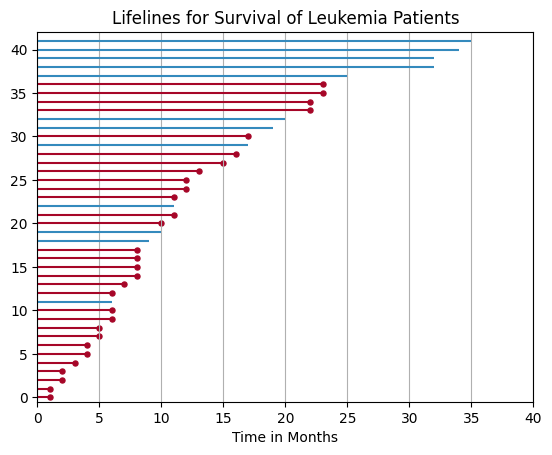

In [6]:
durations = leukemia.t.values
events = leukemia.status.values

ax = lifelines.plotting.plot_lifetimes(durations=durations,
                                       event_observed=events)
ax.set_xlim(0, 40)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Lifelines for Survival of Leukemia Patients");
plt.plot();

## Kaplan-Meier survival estimate

The Kaplan-Meier method estimates survival probability from observed survival times. It results in a step function that changes value only at the time of each event, and confidence intervals can be computed for the survival probabilities.

The **KM survival curve**, a plot of KM survival probability against time, provides a useful summary of the data.
It can be used to estimate measures such as median survival time.

It CANNOT account for risk factors and is NOT regression. It is *non-parametric* (does not involve parameters).

However it is a good way to visualize a survival dataset, and can be **useful to compare the effects of a single categorical variable**.

AttributeError: 'KaplanMeierFitter' object has no attribute 'median_'

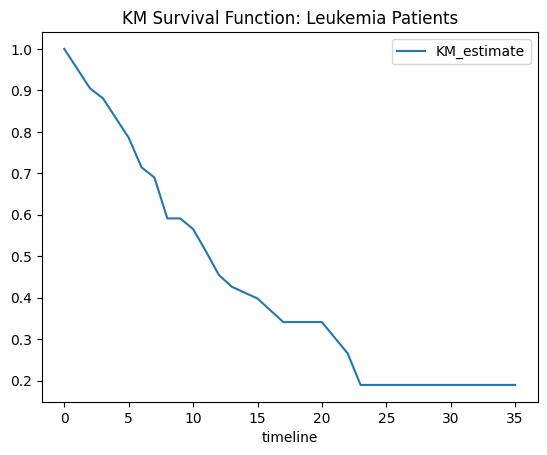

In [9]:
kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations, events)

kmf.survival_function_.plot()
# or kmf.survival_function_.plot.line()
plt.title('KM Survival Function: Leukemia Patients');
print(f'Median Survival: {kmf.median_} months after treatment')

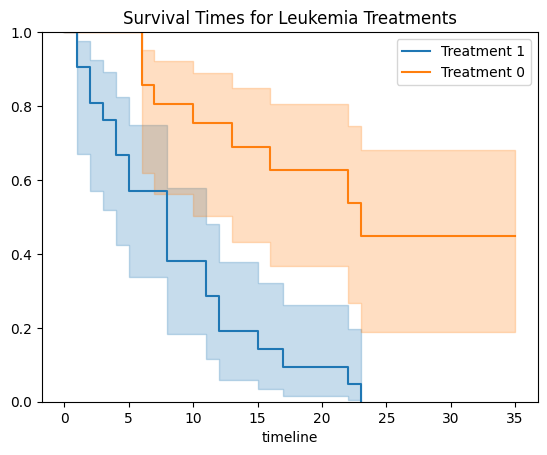

In [12]:
# compare the effects of a single categorical variable, "Rx"
ax = plt.subplot(111)

treatment = (leukemia["Rx"] == 1)
kmf.fit(durations=durations[treatment],
        event_observed=events[treatment],
        label="Treatment 1")
kmf.plot(ax=ax)
# print(f'Median survival time with Treatment 1: {kmf.median_} months')

kmf.fit(durations=durations[~treatment],
        event_observed=events[~treatment],
        label="Treatment 0")
kmf.plot(ax=ax)
# print(f'Median survival time with Treatment 0: {kmf.median_} months')

plt.ylim(0, 1);
plt.title("Survival Times for Leukemia Treatments");

**Note:** more jagged lines because of reduced sample size per group

## Cox Proportional Hazards Model -- Survival Regression
Useful for comparing relative hazards (model accepts entire DataFrame).

It assumes the ratio of death event risks (hazard) of two groups remains about the same over time.
This ratio is called the hazards ratio or the relative risk.

All Cox regression requires is an assumption that ratio of hazards is constant over time across groups.

*The good news* — we don’t need to know anything about overall shape of risk/hazard over time

*The bad news* — the proportionality assumption can be restrictive

In [13]:
# Using Cox Proportional Hazards model
cph = lifelines.CoxPHFitter()
cph.fit(df=leukemia, duration_col='t', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 42 total observations, 12 right-censored observations>
             duration col = 't'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 42
number of events observed = 30
   partial log-likelihood = -69.59
         time fit was run = 2025-01-01 14:57:00 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
sex        0.31      1.37      0.45           -0.58            1.21                0.56                3.34
logWBC     1.68      5.38      0.34            1.02            2.34                2.78               10.40
Rx         1.50      4.50      0.46            0.60            2.41                1.82               11.11

           cmp to    z      p  -log2(p)
covariate                              
sex          0.00 0.69   0.49      1.03
logWBC       0.00 5.00 <0.005     20.71
Rx           0.00 3.26 <0.005      9.80
---
Concordance = 0.85
Partial AIC = 145.18
log-likelihood ratio test = 47.19 on 3 df
-log2(p) of ll-ratio test = 31.55

### Interpreting the Results
`coef`: usually denoted with $b$, the coefficient

`exp(coef)`: $e^{b}$, equals the estimate of the hazard ratio. Here, we can say that participants who received treatment 1 had ~4.5 times the hazard risk (risk of death) compared to those who received treatment 2. And for every unit the `logWBC` increased, the hazard risk increased >5 times.

`se(coef)`: standard error of the coefficient (used for calculating z-score and therefore p-value)

`z`: z-score $\frac{b}{se(b)}$

`p`: p-value. derived from z-score. describes statistical significance. more specifically, it is the likelihood that the variable has no effect on the outcome

`log(p)`: natural logarithm of p-value... used to more easily see differences in significance

`lower/upper 0.95`: confidence levels for the coefficients. in this case, we can confidently say that the coefficient for `logWBC` is somewhere _between_ 1.02 and 2.34.

`Signif. codes`: easily, visually identify significant variables! The more stars, the more solid (simply based on p-value). Here `logWBC` is highly significant, `Rx` is significant, and `sex` has no statistical significance

`Concordance`: a measure of predictive power for classification problems (here looking at the `status` column. a value from 0 to 1 where values above 0.6 are considered good fits (the higher the better)

`Likelihood ratio (LR) test`: this is a measure of how likely it is that the coefficients are not zero, and can compare the goodness of fit of a model versus an alternative null model. Is often actually calculated as a logarithm, resulting in the log-likelihood ratio statistic and allowing the distribution of the test statistic to be approximated with [Wilks' theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem).

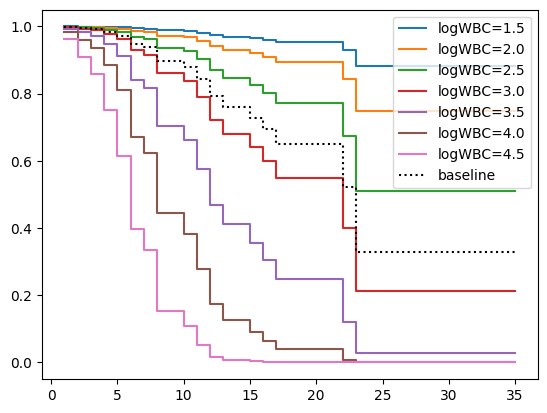

In [15]:
# investigate continuous feature, must bin with 'values' argument
cph.plot_covariate_groups(covariates=['logWBC'], values=np.arange(1.5,5,.5));

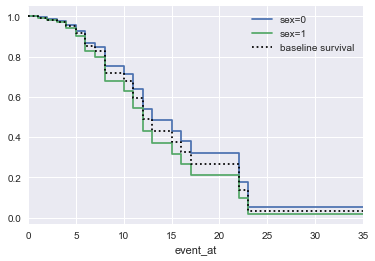

In [ ]:
# categorical feature
cph.plot_covariate_groups(covariate='sex', values=[0,1]);

Check assumption that the **Cox model assumes the ratio of death events between groups remains constant over time**.

In [ ]:
cph.check_assumptions(leukemia)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some covariates
will be below the threshold (i.e. by chance). This is compounded when there are many covariates.

Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and eyeball tests to
determine the most serious violations.


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
             test_statistic    p  -log2(p)
Rx     km              0.23 0.63      0.67
       rank            0.44 0.51      0.98
logWBC km              0.10 0.76      0.40
       rank            0.16 0.68      0.55
sex    km              3.78 0.05      4.27
       rank            4.91 0.03      5.23


1. Variable 'sex' failed the non-proportional test: p-value is 0.0267.
   Advice: with so few 

C:\Users\City_Year\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:900: ConvergenceWarning: Column Rx have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['status'].astype(bool)
>>> df.loc[events, 'Rx'].var()
>>> df.loc[~events, 'Rx'].var()

Too low variance here means that the column Rx completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


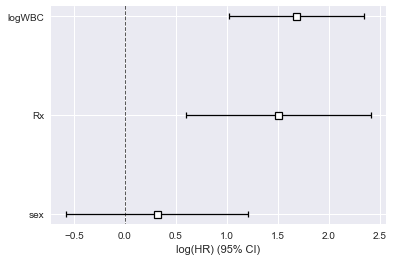

In [ ]:
# We can see that the sex variable is not very useful by plotting the coefficients
cph.plot();

Let's do what the check_assumptions function suggested:

>Advice: with so few unique values (only 2), you can try  `strata=['sex']` in the call in `.fit`.

In [ ]:
cph = lifelines.CoxPHFitter()
cph.fit(df=leukemia, duration_col='t',
        event_col='status', strata=['sex'])
cph.print_summary()
cph.baseline_cumulative_hazard_.shape

<lifelines.CoxPHFitter: fitted with 42 observations, 12 censored>
      duration col = 't'
         event col = 'status'
            strata = ['sex']
number of subjects = 42
  number of events = 30
    log-likelihood = -55.73
  time fit was run = 2019-02-27 00:22:07 UTC

---
        coef  exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
logWBC  1.45       4.28      0.34 4.22 <0.005     15.35        0.78        2.13
Rx      1.00       2.71      0.47 2.11   0.04      4.83        0.07        1.93
---
Concordance = 0.81
Log-likelihood ratio test = 69.61 on 2 df, -log2(p)=50.21


C:\Users\City_Year\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:900: ConvergenceWarning: Column Rx have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['status'].astype(bool)
>>> df.loc[events, 'Rx'].var()
>>> df.loc[~events, 'Rx'].var()

Too low variance here means that the column Rx completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


(24, 2)

This regression:

`Log-likelihood ratio test = 69.61 on 2 df, -log2(p)=50.21`

Regression including `sex`:

`Log-likelihood ratio test = 47.19 on 3 df, -log2(p)=31.55`

The `LRT` and `-log2(p)` are higher, meaning this is likely a better fitting model.

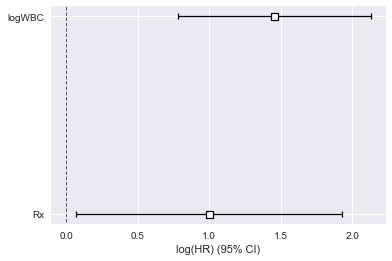

In [ ]:
cph.plot();

In [ ]:
cph.compute_residuals(leukemia, kind='score')

C:\Users\City_Year\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:900: ConvergenceWarning: Column Rx have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['status'].astype(bool)
>>> df.loc[events, 'Rx'].var()
>>> df.loc[~events, 'Rx'].var()

Too low variance here means that the column Rx completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


,logWBC,Rx
34,0.426727,0.337062
17,0.009454,0.022002
18,-1.017077,-0.518252
20,-0.074253,-0.459456
16,0.074935,-0.047861
29,0.362845,-0.013866
30,0.212283,0.116682
31,-0.386970,0.236943
15,0.079720,0.161875
13,0.091508,0.141663


In [ ]:
cph.predict_cumulative_hazard(leukemia[:5])

,0,1,2,3,4
1.0,0.001231,0.001268,0.003663,0.005919,0.001989
2.0,0.002998,0.003086,0.008919,0.014410,0.004844
3.0,0.005017,0.005165,0.014925,0.024114,0.008105
4.0,0.010236,0.010538,0.030452,0.049199,0.016537
5.0,0.015623,0.016084,0.046479,0.075091,0.025241
6.0,0.023143,0.023826,0.068850,0.111234,0.037390
7.0,0.023143,0.023826,0.068850,0.111234,0.037390
8.0,0.034436,0.035452,0.102447,0.165514,0.055635
9.0,0.034436,0.035452,0.102447,0.165514,0.055635
10.0,0.034436,0.035452,0.102447,0.165514,0.055635


,0
0,31.141527
1,31.063377
2,26.570826
3,23.308517
4,29.577589


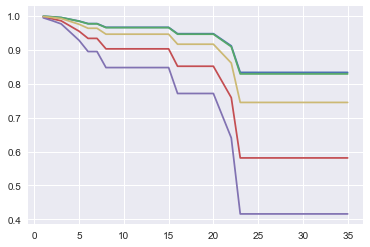

In [ ]:
surv_func = cph.predict_survival_function(leukemia[:5])

exp_lifetime = cph.predict_expectation(leukemia[:5])

plt.plot(surv_func)

exp_lifetime

# Example 2: Recidivism

The Rossi dataset originally comes from Rossi et al. (1980), and is used as an example in Allison (1995).

The data pertain to 432 convicts who were released from Maryland state prisons in the 1970s and who were followed up for one year after release. Half the released convicts were assigned at random to an experimental treatment in which they were given financial aid; half did not receive aid.

In [ ]:
from lifelines.datasets import load_rossi
recidivism = load_rossi()

recidivism.head()

# Looking at the Rossi dataset, how long do you think the study lasted?

# All features are coded with numerical values, but which features do you think
# are actually categorical?

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [ ]:
pd.DataFrame({'dtypes':recidivism.dtypes,
              'nunique':recidivism.nunique()})

,dtypes,nunique
week,int64,49
arrest,int64,2
fin,int64,2
age,int64,28
race,int64,2
wexp,int64,2
mar,int64,2
paro,int64,2
prio,int64,17


In [ ]:
recidivism.describe()

,week,arrest,fin,age,race,wexp,mar,paro,prio
count,432.000000,432.000000,432.00000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,45.854167,0.263889,0.50000,24.597222,0.877315,0.571759,0.122685,0.618056,2.983796
std,12.662293,0.441251,0.50058,6.113375,0.328456,0.495398,0.328456,0.486426,2.896068
min,1.000000,0.000000,0.00000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.00000,20.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,52.000000,0.000000,0.50000,23.000000,1.000000,1.000000,0.000000,1.000000,2.000000
75%,52.000000,1.000000,1.00000,27.000000,1.000000,1.000000,0.000000,1.000000,4.000000
max,52.000000,1.000000,1.00000,44.000000,1.000000,1.000000,1.000000,1.000000,18.000000


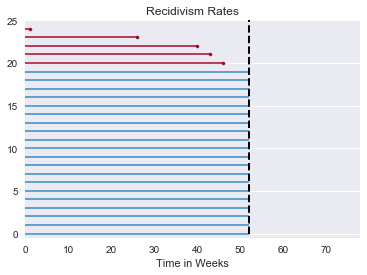

In [ ]:
# plot "lifelines" of the study participants as they attempt to avoid recidivism
recidivism_sample = recidivism.sample(n=25)

duration = recidivism_sample.week.values
arrested = recidivism_sample.arrest.values

ax = lifelines.plotting.plot_lifetimes(duration, event_observed=arrested)
ax.set_xlim(0, 78)
ax.grid(axis='x')
ax.vlines(52, 0, 25, lw=2, linestyles='--')
ax.set_xlabel("Time in Weeks")
ax.set_title("Recidivism Rates");
plt.plot();

In [ ]:
kmf = lifelines.KaplanMeierFitter()

duration = recidivism.week
arrested = recidivism.arrest

kmf.fit(duration, arrested)

<lifelines.KaplanMeierFitter: fitted with 432 observations, 318 censored>

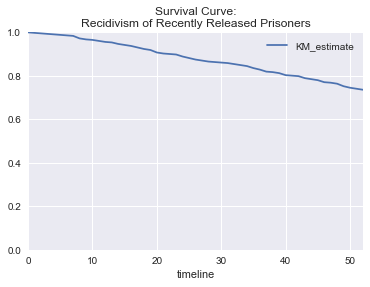

In [ ]:
kmf.survival_function_.plot()
plt.title('Survival Curve:\nRecidivism of Recently Released Prisoners')
plt.ylim(0,1);

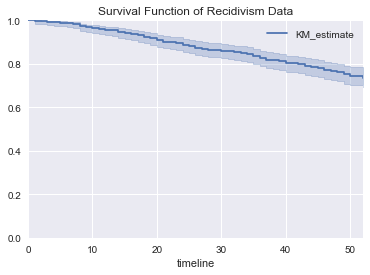

In [ ]:
kmf.plot()
plt.title('Survival Function of Recidivism Data')
plt.ylim(0,1);

In [ ]:
print(f'Median time before recidivism: {kmf.median_} weeks')

Median time before recidivism: inf weeks


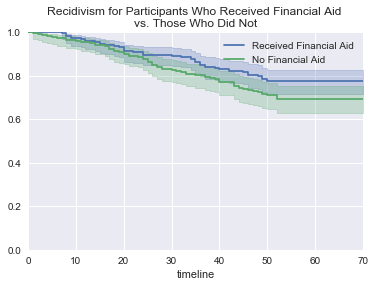

In [ ]:
kmf_w_aid = lifelines.KaplanMeierFitter()
kmf_no_aid = lifelines.KaplanMeierFitter()

ax = plt.subplot(111)

w_aid = (recidivism['fin']==1)

t = np.linspace(0, 70, 71)
kmf_w_aid.fit(duration[w_aid], event_observed=arrested[w_aid],
              timeline=t, label="Received Financial Aid")
ax = kmf_w_aid.plot(ax=ax)
#print("Median survival time of democratic:", kmf.median_)

kmf_no_aid.fit(duration[~w_aid], event_observed=arrested[~w_aid],
               timeline=t, label="No Financial Aid")
ax = kmf_no_aid.plot(ax=ax)
#print("Median survival time of non-democratic:", kmf.median_)

plt.ylim(0,1)
plt.title("Recidivism for Participants Who Received Financial Aid \nvs. Those Who Did Not");

          NA_estimate
timeline             
0.0          0.000000
1.0          0.002315
2.0          0.004635
3.0          0.006961
4.0          0.009292


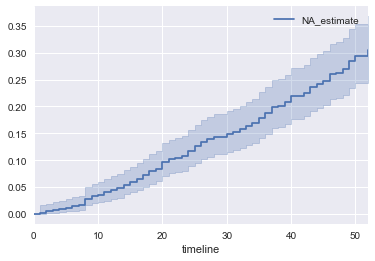

In [ ]:
naf = lifelines.NelsonAalenFitter()
naf.fit(duration, arrested)

print(naf.cumulative_hazard_.head())
naf.plot();

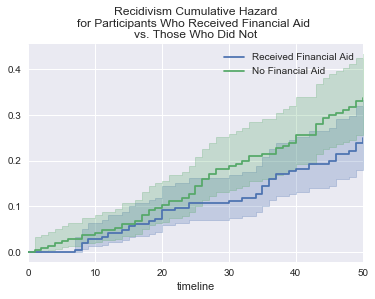

In [ ]:
naf_w_aid = lifelines.NelsonAalenFitter()
naf_no_aid = lifelines.NelsonAalenFitter()

naf_w_aid.fit(duration[w_aid], event_observed=arrested[w_aid],
              timeline=t, label="Received Financial Aid")
ax = naf_w_aid.plot(loc=slice(0, 50))
naf_no_aid.fit(duration[~w_aid], event_observed=arrested[~w_aid],
               timeline=t, label="No Financial Aid")
ax = naf_no_aid.plot(ax=ax, loc=slice(0, 50))
plt.title("Recidivism Cumulative Hazard\n"
          "for Participants Who Received Financial Aid \n"
          "vs. Those Who Did Not");

In [ ]:
cph = lifelines.CoxPHFitter()
cph.fit(recidivism, duration_col='week',
        event_col='arrest', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.48337, step_size = 0.9500, ll = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13160, step_size = 0.9500, ll = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01712, step_size = 0.9500, ll = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00108, step_size = 1.0000, ll = -658.74771, newton_decrement = 0.00005, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-02-27 00:22:32 UTC

---
      coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  uppe

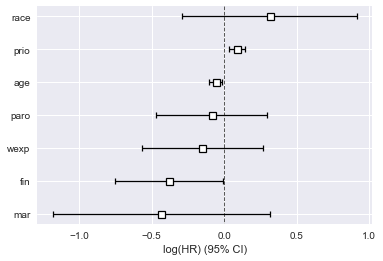

In [ ]:
cph.plot();

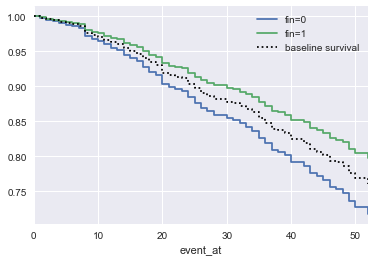

In [ ]:
cph.plot_covariate_groups('fin', [0, 1]);

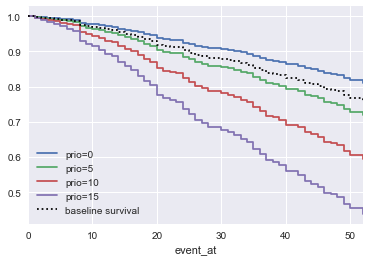

In [ ]:
cph.plot_covariate_groups('prio', [0, 5, 10, 15]);

In [ ]:
r = cph.compute_residuals(recidivism, 'martingale')
r.head()

,week,arrest,martingale
313,1.0,True,0.997048
100,2.0,True,0.998585
183,3.0,True,0.993959
416,4.0,True,0.987465
79,5.0,True,0.979341


In [ ]:
cph.check_assumptions(recidivism)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some covariates
will be below the threshold (i.e. by chance). This is compounded when there are many covariates.

Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and eyeball tests to
determine the most serious violations.


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.09 <0.005     10.17
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.16
mar  km              0.60   0.44      1.19
     rank            0.67   0.41      1.27
paro km              0.12   0.73      0.45
     rank            0.14   0.71      0.49
prio km   

# Example 3: Heart Attack Survival

https://archive.ics.uci.edu/ml/datasets/echocardiogram

In [ ]:
# TODO

# Example 4: Customer Churn

Treselle Systems, a data consulting service, [analyzed customer churn data using logistic regression](http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/). For simply modeling whether or not a customer left, logistic can work, but if we want to model the actual tenure of a customer, survival analysis is more appropriate.

The "tenure" feature represents the duration that a given customer has been with them, and "churn" represents whether or not that customer left (i.e. the "event", from a survival analysis perspective).

data source: https://github.com/treselle-systems/customer_churn_analysis

- What features best model customer churn?
- What would you characterize as the "warning signs" that a customer may discontinue service?
- What actions would you recommend to this business to try to improve their customer retention?

Please create at least *3* plots or visualizations to support your findings, and in general write your summary/results targeting an "interested layperson" (e.g. your hypothetical business manager) as your audience.

This means that, as is often the case in data science, there isn't a single objective right answer - your goal is to *support* your answer, whatever it is, with data and reasoning.

In [ ]:
churn_data = pd.read_csv('https://raw.githubusercontent.com/'
                         'treselle-systems/customer_churn_analysis/'
                         'master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
event_col = 'Churn'
duration_col = 'tenure'

churn_data[event_col] = churn_data[event_col].map({'No':0, 'Yes':1})

predictors = sorted(list(set(churn_data.columns) - set([event_col, duration_col])))

In [ ]:
pd.DataFrame({'dtypes':churn_data[predictors].dtypes,
              'nunique':churn_data[predictors].nunique()})

,dtypes,nunique
Contract,object,3
Dependents,object,2
DeviceProtection,object,3
InternetService,object,3
MonthlyCharges,float64,1585
MultipleLines,object,3
OnlineBackup,object,3
OnlineSecurity,object,3
PaperlessBilling,object,2
Partner,object,2


`TotalCharges` should be numeric, contains ' '

In [ ]:
# InternetService was perfectly collienar with StreamingMovies and StreamingTV
to_dummy = ['Partner', 'InternetService', 'SeniorCitizen',
            'gender', 'Dependents', 'Contract']

In [ ]:
for col in to_dummy:
    print(col, '\n', churn_data[col].value_counts(),
          '\n\n', sep='')

Partner
No     3641
Yes    3402
Name: Partner, dtype: int64


InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64


SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64


gender
Male      3555
Female    3488
Name: gender, dtype: int64


Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64


Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64




In [ ]:
churn_data['Contract'] = churn_data['Contract'].map({'Month-to-month':'No'})
churn_data['gender'] = churn_data['gender'].map({'Male':'No'})

In [ ]:
for col in to_dummy:
    if 'No' in churn_data[col].unique():
        churn_data[col] = churn_data[col].map({'No':0}).fillna(1)

In [ ]:
predictors = to_dummy

In [ ]:
churn_data[[event_col, duration_col] + predictors].corr()

,Churn,tenure,Partner,InternetService,SeniorCitizen,gender,Dependents,Contract
Churn,1.000000,-0.352229,-0.150448,0.227890,0.150889,0.008612,-0.164221,-0.405103
tenure,-0.352229,1.000000,0.379697,0.039062,0.016567,-0.005106,0.159712,0.645561
Partner,-0.150448,0.379697,1.000000,-0.000615,0.016479,0.001808,0.452676,0.280865
InternetService,0.227890,0.039062,-0.000615,1.000000,0.182742,0.006026,-0.139812,-0.218639
SeniorCitizen,0.150889,0.016567,0.016479,0.182742,1.000000,0.001874,-0.211185,-0.138360
gender,0.008612,-0.005106,0.001808,0.006026,0.001874,1.000000,-0.010517,-0.003386
Dependents,-0.164221,0.159712,0.452676,-0.139812,-0.211185,-0.010517,1.000000,0.231720
Contract,-0.405103,0.645561,0.280865,-0.218639,-0.138360,-0.003386,0.231720,1.000000


In [ ]:
cph = lifelines.CoxPHFitter()
cph.fit(churn_data[[event_col, duration_col] + predictors],
        duration_col=duration_col, event_col=event_col)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7043
  number of events = 1869
    log-likelihood = -14323.25
  time fit was run = 2019-02-27 16:00:43 UTC

---
                 coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
Partner         -0.60       0.55      0.05 -11.10 <0.005     92.64       -0.71       -0.50
InternetService  0.59       1.81      0.10   5.97 <0.005     28.63        0.40        0.79
SeniorCitizen    0.02       1.02      0.06   0.32   0.75      0.42       -0.09        0.13
gender           0.03       1.04      0.05   0.75   0.45      1.14       -0.06        0.13
Dependents      -0.15       0.86      0.07  -2.13   0.03      4.93       -0.28       -0.01
Contract        -2.78       0.06      0.08 -33.85 <0.005    831.82       -2.94       -2.62
---
Concordance = 0.81
Log-likelihood ratio test = 2659.57 on 6 df, -log2(p)=inf


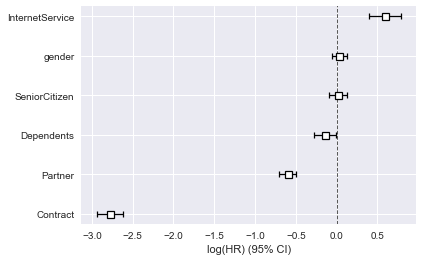

In [ ]:
cph.plot();

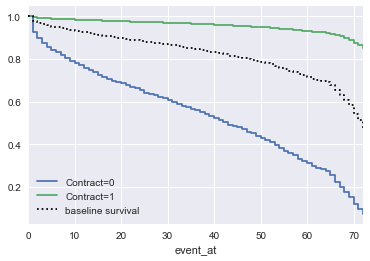

In [ ]:
# categorical feature
cph.plot_covariate_groups(covariate='Contract', values=[0,1]);

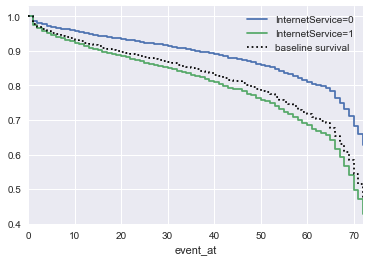

In [ ]:
# categorical feature
cph.plot_covariate_groups(covariate='InternetService', values=[0,1]);

In [ ]:
cph.check_assumptions(churn_data[[event_col, duration_col] + predictors])


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some covariates
will be below the threshold (i.e. by chance). This is compounded when there are many covariates.

Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and eyeball tests to
determine the most serious violations.


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                      test_statistic      p  -log2(p)
Contract        km             85.28 <0.005     65.07
                rank           69.59 <0.005     53.61
Dependents      km              0.62   0.43      1.22
                rank            0.67   0.41      1.28
InternetService km             28.91 <0.005     23.65
                rank           32.29 <0.005     26.16
Partner         km 